In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
import sys
sys.path.append("../../../spatial-clust-scripts-main/")
import model
import warnings
import numpy as np
import leidenalg
import igraph as ig
import scanpy as sc
import anndata as ad
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
import graph
import pandas as pd
import scipy
import skimage
# import custom functions
import utils
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import seaborn as sns
import umap
# from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from validclust import dunn
from sklearn.metrics import pairwise_distances
plt.rcParams["figure.figsize"] = (8, 6)


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### script for getting benchmarking with only Spatial-GNN

### also get loss information within same script

In [2]:
## during testing only test snap_gnn

class SNAP_GNN(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.fc = nn.Linear(in_features=args.gnn_input_dim, out_features=args.fc_dim)
        self.cnn_fc = nn.Linear(in_features=args.cnn_input_dim, out_features=args.cnn_dim)
        self.feat_conv1 = GCNConv(args.fc_dim, args.latent_dim)
        self.feat_conv2 = GCNConv(args.latent_dim, args.fc_out_dim)
        
        self.spat_conv1 = GCNConv(args.cnn_dim, args.cnn_latent_dim)
        self.spat_conv2 = GCNConv(args.cnn_latent_dim, args.cnn_out_dim)
        
        self.proj1 = nn.Linear(in_features=args.fc_out_dim+args.cnn_out_dim, 
                              out_features=args.hid_out_dim)
        self.proj2 = nn.Linear(in_features=args.hid_out_dim, 
                              out_features=args.out_dim)

    def feat_gnn_encoder(self, feat, feat_edge_index):
        feat = F.relu(self.fc(feat))
        feat = F.relu(self.feat_conv1(feat, feat_edge_index))
        feat = self.feat_conv2(feat, feat_edge_index)
        
        return feat
    
    def spat_gnn_encoder(self, spat, spat_edge_index):
        spat = F.relu(self.cnn_fc(spat))
        spat = F.relu(self.spat_conv1(spat, spat_edge_index))
        spat = self.spat_conv2(spat, spat_edge_index)
        
        return spat
    
    def encoder(self, feat, spat, feat_edge_index, spat_edge_index):
        x_feat = self.feat_gnn_encoder(feat, feat_edge_index)
        x_spat = self.spat_gnn_encoder(spat, spat_edge_index)
        x = torch.cat((x_feat, x_spat), dim = 1)
        return x
    

    def forward(self, feat, spat, feat_edge_index, spat_edge_index):
        x = F.relu(self.encoder(feat, spat, feat_edge_index, spat_edge_index))
        x = self.proj1(x)
        x = F.relu(x)
        x = self.proj2(x)
        return x


In [3]:
class Args:
    gnn_input_dim = 31
    cnn_input_dim = 128
    #fc_dim = latent_dim = 32
    # sGNN only so set all to 0
    fc_dim = latent_dim = 0
    cnn_dim = cnn_latent_dim = 32

    # out_dim = 14 * 2 # dont know this value yet
    #fc_out_dim = 33 # sgnn only set to 0
    fc_out_dim = 0
    cnn_out_dim = 11
    hid_out_dim = 33

    criterion = "L1"
    learning_rate = 1e-3
    epochs = 10000
    print_every = 1000
    average_iter = 100
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

args = Args()

In [4]:
def get_gnn_embed(model, cell_nbhd, feat, spat, feat_edge_index, spat_edge_index, verbose=False):
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
    cell_nbhd = cell_nbhd.to(args.device)
    model = model.to(args.device)
    if args.criterion == "L1":
        print("Use L1 Loss")
        criterion = nn.L1Loss()
    elif args.criterion == "L2":
        print("Use L2 Loss")
        criterion = nn.MSELoss()
    else:
        print("Cross Entropy")
        criterion = nn.CrossEntropyLoss()

    train_loss_epoch = []
    #criterion = nn.L1Loss()
    for e in range(1, 1+args.epochs):
        model.train()
        predicted_nbhd = model(features, cnn_embedding, feat_edge_index, spat_edge_index)
        # Compute prediction error
        loss = criterion(predicted_nbhd, cell_nbhd)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # take one step
        optimizer.step()

        # record the loss
        curr_train_loss = loss.item()
        if verbose and e % args.print_every  == 0:
            print(f'===Epoch {e}, the training loss is {curr_train_loss:>0.8f}==', flush=True)
        train_loss_epoch.append(curr_train_loss)
    return model.encoder(feat, spat, feat_edge_index, spat_edge_index).cpu().detach().numpy()


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


0
Use L1 Loss
===Epoch 1000, the training loss is 0.05500527==
===Epoch 2000, the training loss is 0.05130855==
===Epoch 3000, the training loss is 0.05015516==
===Epoch 4000, the training loss is 0.05003955==
===Epoch 5000, the training loss is 0.04986633==
===Epoch 6000, the training loss is 0.04983039==
===Epoch 7000, the training loss is 0.04983760==
===Epoch 8000, the training loss is 0.04938890==
===Epoch 9000, the training loss is 0.04929842==
===Epoch 10000, the training loss is 0.04892378==
1
Use L1 Loss


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


===Epoch 1000, the training loss is 0.05783117==
===Epoch 2000, the training loss is 0.05604502==
===Epoch 3000, the training loss is 0.05564795==
===Epoch 4000, the training loss is 0.05555924==
===Epoch 5000, the training loss is 0.05493837==
===Epoch 6000, the training loss is 0.05132291==
===Epoch 7000, the training loss is 0.05008163==
===Epoch 8000, the training loss is 0.04985998==
===Epoch 9000, the training loss is 0.04894489==
===Epoch 10000, the training loss is 0.04869372==
2
Use L1 Loss
===Epoch 1000, the training loss is 0.05492912==
===Epoch 2000, the training loss is 0.05122086==
===Epoch 3000, the training loss is 0.05073532==
===Epoch 4000, the training loss is 0.04874578==
===Epoch 5000, the training loss is 0.04830897==
===Epoch 6000, the training loss is 0.04820567==
===Epoch 7000, the training loss is 0.04756939==
===Epoch 8000, the training loss is 0.04740723==
===Epoch 9000, the training loss is 0.04716585==
===Epoch 10000, the training loss is 0.04598466==
3
Us

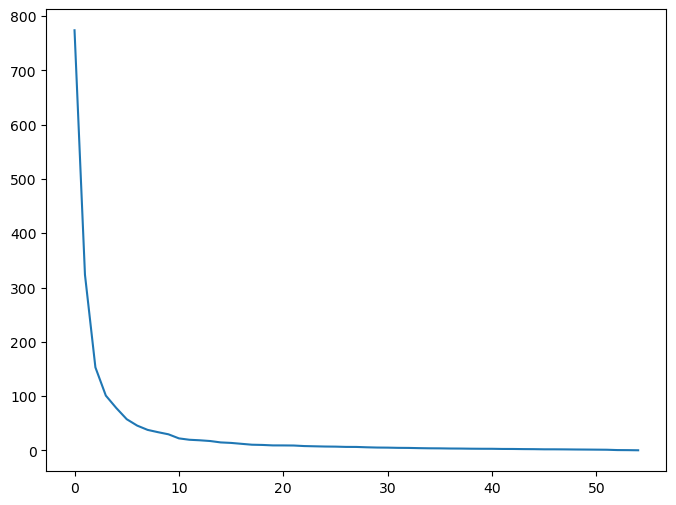

In [5]:
### input
#size = 512
l = 1
d = defaultdict(list)

# input all default
metaload_path = '/mnt/cloud1/sheng-projects/st_projects/spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/benchmark/spleen/data/'
df_clean = pd.read_csv('/mnt/cloud1/sheng-projects/st_projects/spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/spleen/data/features_and_metadata.csv', index_col=0)
features = np.load('/mnt/cloud1/sheng-projects/st_projects/spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/spleen/data/feature_scaled.npy')

cell_nbhd = np.load(os.path.join(metaload_path,  f"cell_nbhd_res0.5_k20.npy")) # all default settings
train_mask = np.load(os.path.join(metaload_path,  "train_mask.npy"))
feature_labels = np.load(os.path.join(metaload_path,  "feature_labels_res0.5.npy"))
feature_edges = np.load(os.path.join(metaload_path,  "feature_edges_res0.5.npy"))
spatial_edges = np.load(os.path.join(metaload_path,  "spatial_edges_0326.npy"))                       
                        
# change into torch
features = torch.from_numpy(features).float().to(args.device)
feat_edge_index = torch.from_numpy(np.array(feature_edges.T[:2])).long().to(args.device)
spat_edge_index = torch.from_numpy(np.array(spatial_edges.T[:2])).long().to(args.device)

# combo nbhd                       
df_clean['res'] = feature_labels
reslabel = pd.get_dummies(df_clean['res'])
combo_nbhd = np.hstack([reslabel, cell_nbhd])
combo_nbhd = torch.from_numpy(combo_nbhd).float().to(args.device)

## cnn
load_path = '/mnt/cloud1/sheng-projects/st_projects/spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/benchmark/spleen/data/'
save_folder = os.path.join(load_path, "cnn", f"cnn_512_l1_layer6_testres:0.5_checkpoints", "epochs", 'embed')
args.out_dim = combo_nbhd.shape[1]

#### reset args here
class Args:
    gnn_input_dim = 31
    cnn_input_dim = 128
    #fc_dim = latent_dim = 32
    # sGNN only so set all to 0
    fc_dim = latent_dim = 0
    cnn_dim = cnn_latent_dim = 32

    out_dim = combo_nbhd.shape[1]
    #fc_out_dim = 33 # sgnn only set to 0
    fc_out_dim = 0
    cnn_out_dim = 11
    hid_out_dim = 33

    criterion = "L1"
    learning_rate = 1e-3
    epochs = 10000
    print_every = 1000
    average_iter = 100
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

args = Args()
#### reseat args finished

# get cnn embedding
epoch = 400
cnn_embedding = np.load(os.path.join(save_folder, f'cnn_512_testres:0.5_l1_layer6_byepoch' ,f"cnn_embedding_512_full_l1_dim128_epoch{epoch}.npy"))
cnn_embedding = torch.from_numpy(cnn_embedding).float().to(args.device)
cnn = cnn_embedding

stable = True
if stable:
    rep = 5
    dim = args.fc_out_dim + args.cnn_out_dim
    concat_embedding = np.zeros((features.shape[0], rep * dim))
    for i in range(rep):
        print(i)
        gnn_embedding = get_gnn_embed(SNAP_GNN(args), combo_nbhd, features, cnn, feat_edge_index, spat_edge_index, verbose=True)
        concat_embedding[:, i*dim : (i+1)*dim] = gnn_embedding
    Ue, Se, Vhe = np.linalg.svd(concat_embedding, full_matrices=False)

    plt.plot(Se)
    k = 32
    gnn_embedding = Ue[:, :k] @ np.diag(Se[:k])
else:
    gnn_embedding = get_gnn_embed(SNAP_GNN(args), combo_nbhd, features, cnn, feat_edge_index, spat_edge_index, verbose=True)

## save out
dir = '../data/saved_embedding/bench_SGNNonly_dbGNN_with_0326.npy'
np.save(dir, gnn_embedding)


### start producing loss

In [6]:
def train_gnn_get_testloss(features = None, cnn_feature = None, feat_edge_index = None,
                           spat_edge_index = None, cell_nbhd = None, train_mask = None, model = None, 
                           args = args, verbose = False): # cell_nbhd not used change to combo_nbhd
    
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
    train_nbhd = cell_nbhd[train_mask].to(args.device)
    test_nbhd = cell_nbhd[~train_mask].to(args.device)
    model = model.to(args.device)
    if args.criterion == "L1":
        print("Use L1 Loss")
        criterion = nn.L1Loss()
    elif args.criterion == "L2":
        print("Use L2 Loss")
        criterion = nn.MSELoss()
    else:
        print("Cross Entropy")
        criterion = nn.CrossEntropyLoss()
    
    train_loss_epoch = []
    test_loss_epoch = []
    #criterion = nn.L1Loss()
    for e in range(1, 1+args.epochs):
        model.train()
        if cnn_feature != None:
            predicted_nbhd = model(features, cnn_feature, feat_edge_index, spat_edge_index)
        else:
            predicted_nbhd = model(x=features,  edge_index=edge_index) # actually not used this line
        
        # Compute prediction error
        loss = criterion(predicted_nbhd[train_mask], train_nbhd)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # take one step
        optimizer.step()

        # record the loss
        curr_train_loss = loss.item()
        if verbose and e % args.print_every  == 0:
            print(f'===Epoch {e}, the training loss is {curr_train_loss:>0.8f}==', flush=True)
        train_loss_epoch.append(curr_train_loss)

        model.eval()
        with torch.no_grad():
            if cnn_feature != None:
                predicted_nbhd = model(features, cnn_feature, feat_edge_index, spat_edge_index)
            else:
                predicted_nbhd = model(x=features, edge_index=edge_index) # again not used here
            loss = criterion(predicted_nbhd[~train_mask], test_nbhd)
            curr_test_loss = loss.item()
            if verbose and e % args.print_every == 0:
                print(f'===Epoch {e}, the test loss is {curr_test_loss:>0.8f}===', flush=True)
            test_loss_epoch.append(curr_test_loss)
    #return test_loss_epoch
    return  np.mean(test_loss_epoch[-args.average_iter:])

In [7]:
cnn = cnn_embedding
cri = ["L1", "L2", "CE"]

## start getting loss
for i in tqdm(range(5)):
    for c in cri:
        args.criterion = c
        model = SNAP_GNN(args)
        
        print([features.shape, cnn_embedding.shape, combo_nbhd.shape])
        new_loss = train_gnn_get_testloss(features = features, cnn_feature = cnn_embedding, feat_edge_index = feat_edge_index,
                    spat_edge_index = spat_edge_index, cell_nbhd = combo_nbhd, train_mask = train_mask,
                    model = model, 
                    args = args, verbose = False)
        
        d["Loss"].append(new_loss)
        d["Loss_type"].append(c)
        d["Model"].append("sGNN")


  0%|          | 0/5 [00:00<?, ?it/s]

[torch.Size([53500, 31]), torch.Size([53500, 128]), torch.Size([53500, 28])]
Use L1 Loss
[torch.Size([53500, 31]), torch.Size([53500, 128]), torch.Size([53500, 28])]
Use L2 Loss
[torch.Size([53500, 31]), torch.Size([53500, 128]), torch.Size([53500, 28])]
Cross Entropy


 20%|██        | 1/5 [21:34<1:26:17, 1294.37s/it]

[torch.Size([53500, 31]), torch.Size([53500, 128]), torch.Size([53500, 28])]
Use L1 Loss
[torch.Size([53500, 31]), torch.Size([53500, 128]), torch.Size([53500, 28])]
Use L2 Loss
[torch.Size([53500, 31]), torch.Size([53500, 128]), torch.Size([53500, 28])]
Cross Entropy


 40%|████      | 2/5 [33:30<47:42, 954.33s/it]   

[torch.Size([53500, 31]), torch.Size([53500, 128]), torch.Size([53500, 28])]
Use L1 Loss
[torch.Size([53500, 31]), torch.Size([53500, 128]), torch.Size([53500, 28])]
Use L2 Loss
[torch.Size([53500, 31]), torch.Size([53500, 128]), torch.Size([53500, 28])]
Cross Entropy


 60%|██████    | 3/5 [45:25<28:09, 844.89s/it]

[torch.Size([53500, 31]), torch.Size([53500, 128]), torch.Size([53500, 28])]
Use L1 Loss
[torch.Size([53500, 31]), torch.Size([53500, 128]), torch.Size([53500, 28])]
Use L2 Loss
[torch.Size([53500, 31]), torch.Size([53500, 128]), torch.Size([53500, 28])]
Cross Entropy


 80%|████████  | 4/5 [1:22:17<23:04, 1384.74s/it]

[torch.Size([53500, 31]), torch.Size([53500, 128]), torch.Size([53500, 28])]
Use L1 Loss
[torch.Size([53500, 31]), torch.Size([53500, 128]), torch.Size([53500, 28])]
Use L2 Loss
[torch.Size([53500, 31]), torch.Size([53500, 128]), torch.Size([53500, 28])]
Cross Entropy


100%|██████████| 5/5 [1:59:47<00:00, 1437.54s/it]


In [8]:
df = pd.DataFrame.from_dict(d)
df.to_csv('../data/singVsduo/sgnnolny_loss_0326.csv')
df

,Loss,Loss_type,Model
0,0.046721,L1,sGNN
1,0.026078,L2,sGNN
2,4.529291,CE,sGNN
3,0.046139,L1,sGNN
4,0.026048,L2,sGNN
5,4.517340,CE,sGNN
6,0.052679,L1,sGNN
7,0.026260,L2,sGNN
8,4.485520,CE,sGNN
9,0.046393,L1,sGNN


In [9]:
dd = pd.DataFrame(gnn_embedding)
dd.to_csv('../data/saved_embedding/bench_SGNNonly_dbGNN_with_0326.csv')